In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U spacy
!pip install scispacy

In [ ]:
!pip install render

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz

In [6]:
import scispacy
import spacy
#Core models
import en_core_sci_sm
import en_core_sci_md
#NER specific models
import en_ner_bc5cdr_md
#Tools for extracting & displaying data
from spacy import displacy
import pandas as pd

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1
    word_count = len(vocab.keys())
    return sent_count,word_count

In [56]:
clinical_text_df = pd.read_csv("/content/drive/MyDrive/mtsamples.csv")

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [57]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [58]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


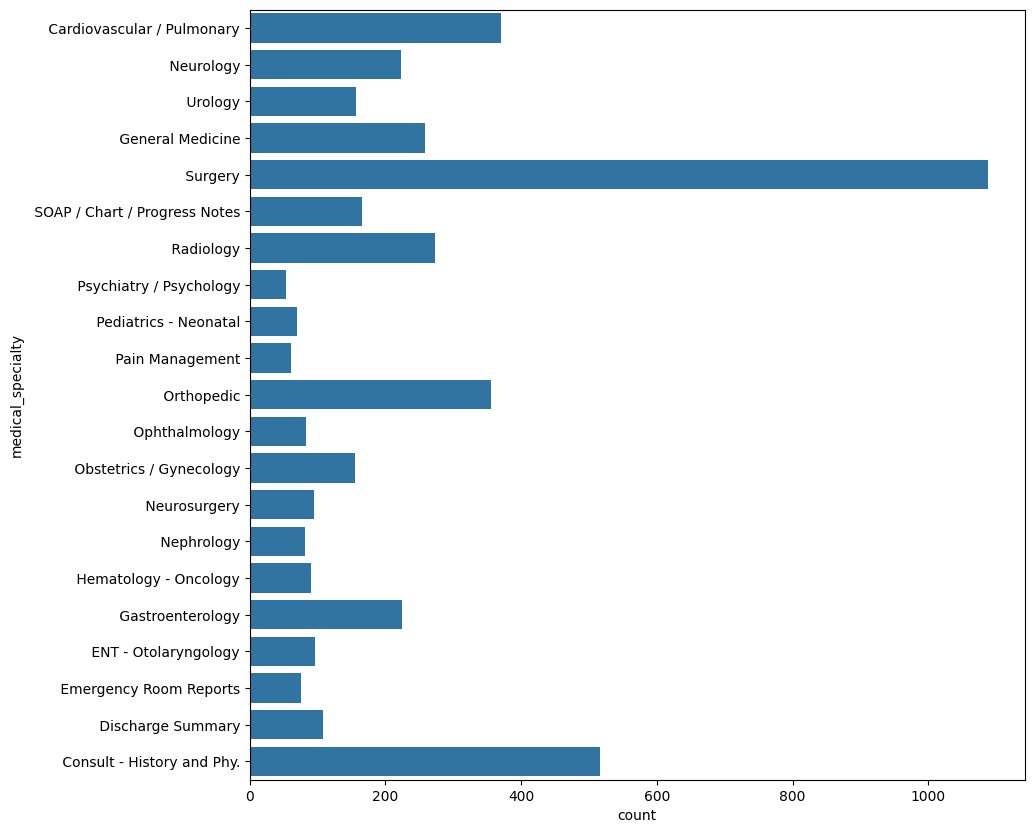

In [59]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [60]:
# x ve y değişkenleri olarak kullanılacak sütunlar alınır
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [61]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

# **Data Cleaning and Preprocess**

In [62]:
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)

    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]

    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)


data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [63]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

Sample Transcription 2:admitting diagnoses    this is scheduled for the week after discharge potentially by dr g  and the patient will discus the exact time later this week 

Sample Transcription 3:preoperative diagnoses   phimosis and adhesions  postoperative diagnoses   phimosis and adhesions  procedures performed   circumcision and release of ventral chordee  anesthesia   local mac  estimated blood loss   minimal  fluids   crystalloid  plan wa for removal of the dressing tomorrow 


### **Count Vectorizer COre**

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
countMat  = count_vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(count_vectorizer.get_feature_names_out())
print(feature_names)

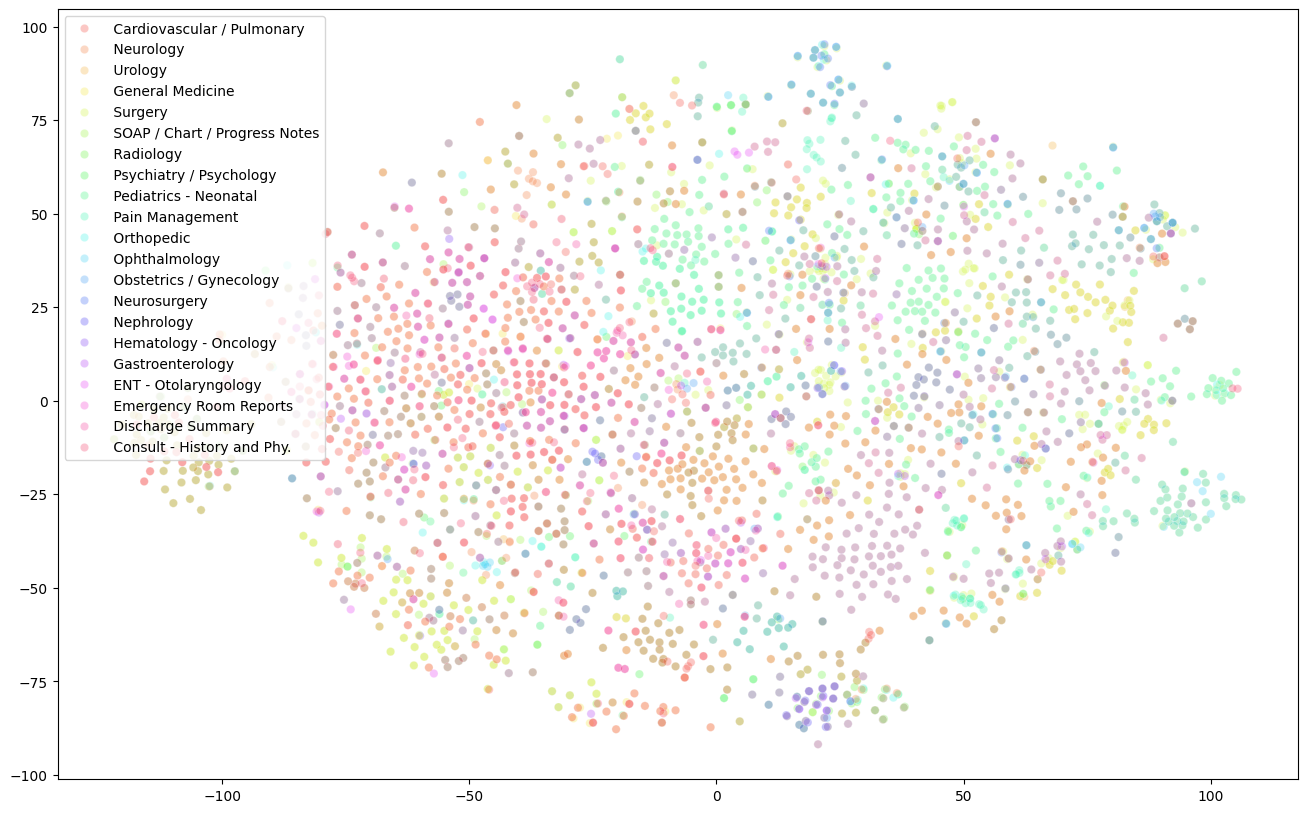

In [67]:
import gc
gc.collect()
tfIdfMatrix = np.array(tfIdfMat.todense())
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [100]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = tfidf_vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(tfidf_vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen patient', 'abdomen pelvis', 'abdominal', 'abdominal aorta', 'abdominal patient', 'abdominal wall', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adhesion', 'adnexal', 'adrenal', 'adrenal gland', 'air', 'air cell', 'airway', 'airway patient', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allograft', 'alt', 'amniotic', 'amniotic fluid', 'anal', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior artery', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior descending', 'anterior posterior', 'anterolateral', 'antrum', 'aorta', 'aorta left', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'apical', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery anterior', 'artery artery', 'artery carotid', 'artery carotid artery', 'artery coronary', 'artery coronary artery', 'artery left', 'artery patient', 'artery 

In [101]:
gc.collect()
pca = PCA(n_components=0.95)

tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

### **prep**

In [102]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [103]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

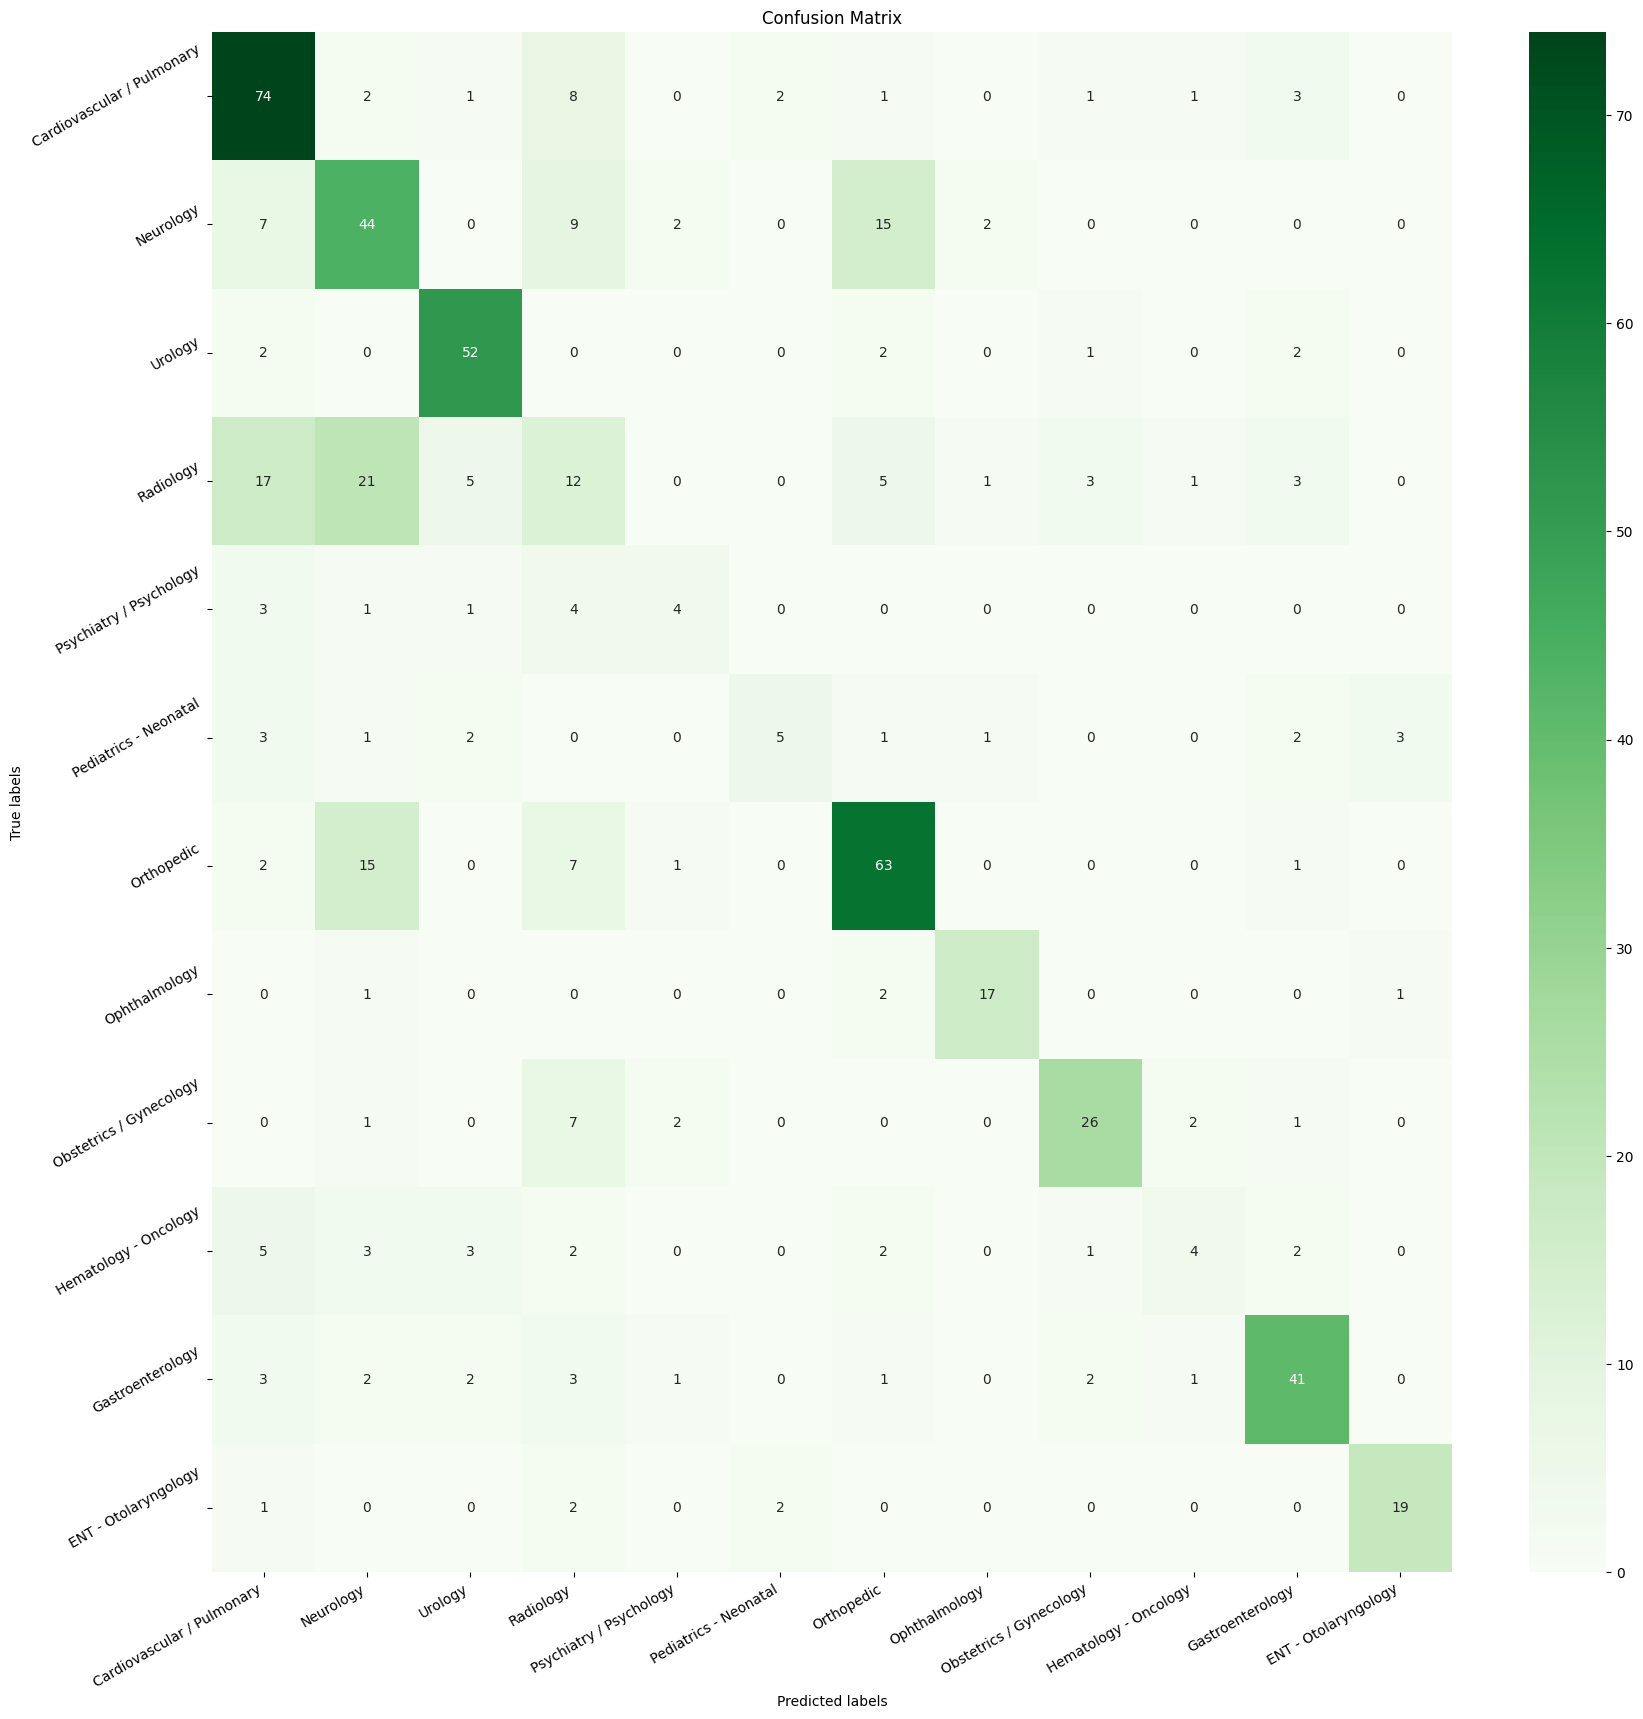

In [104]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [105]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.63      0.80      0.70        93
                 Neurology       0.48      0.56      0.52        79
                   Urology       0.79      0.88      0.83        59
                 Radiology       0.22      0.18      0.20        68
   Psychiatry / Psychology       0.40      0.31      0.35        13
     Pediatrics - Neonatal       0.56      0.28      0.37        18
                Orthopedic       0.68      0.71      0.70        89
             Ophthalmology       0.81      0.81      0.81        21
   Obstetrics / Gynecology       0.76      0.67      0.71        39
     Hematology - Oncology       0.44      0.18      0.26        22
          Gastroenterology       0.75      0.73      0.74        56
      ENT - Otolaryngology       0.83      0.79      0.81        24

                  accuracy                           0.62       581
                 macro avg       0.61      0.5

In [106]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 ENT - Otolaryngology : 96
Cat:3 Gastroenterology : 224
Cat:4 Hematology - Oncology : 90
Cat:5 Neurology : 317
Cat:6 Obstetrics / Gynecology : 155
Cat:7 Ophthalmology : 83
Cat:8 Orthopedic : 355
Cat:9 Pediatrics - Neonatal : 70
Cat:10 Psychiatry / Psychology : 53
Cat:11 Radiology : 273
Cat:12 Urology : 237
============Reduced Categories======================


(2324, 2)

In [107]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz (120.2 MB)
  Preparing metadata (setup.py) ... done


In [108]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

In [109]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

In [110]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [111]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:head rue pronator extremity cbc gs ua ptt crp left caudate subcortical lacunar infarct edema left caudate nucleus arterial left mca fibromuscular ana anticardiolipin antibody cardiac enzyme b cholesterol left mca left mca collateral left aca mca collateral vascular caliber moya medications  in cervical biopsy stage iv squamous cell cancer cervix cervical cancer

Sample Transcription 2:renal renal ureteral renal ureteral stent urine patient kidney patient dorsal lithotomy ureter patient bladder patient prostate bladder patient bladder ureteral catheter bladder bladder ureter upj ureteral dilating ureter upj ureter upj upj papillary  biopsy forceps biopsy papillary bladder ureteral stent bladder bladder patient back patient patient

Sample Transcription 3:uterine uterine uterine uterine vaginal endotracheal anesthesia  description endotracheal patient dorsal lithotomy vagina anterior lip uterine cervix uterus uterine singletooth tenaculum vagina marcaine epinephrin

In [112]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = tfidf_vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(tfidf_vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen patient', 'abdomen pelvis', 'abdominal', 'abdominal aorta', 'abdominal patient', 'abdominal wall', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adhesion', 'adnexal', 'adrenal', 'adrenal gland', 'air', 'air cell', 'airway', 'airway patient', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allograft', 'alt', 'amniotic', 'amniotic fluid', 'anal', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior artery', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior descending', 'anterior posterior', 'anterolateral', 'antrum', 'aorta', 'aorta left', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'apical', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery anterior', 'artery artery', 'artery carotid', 'artery carotid artery', 'artery circumflex', 'artery coronary', 'artery coronary artery', 'artery left', 'arte

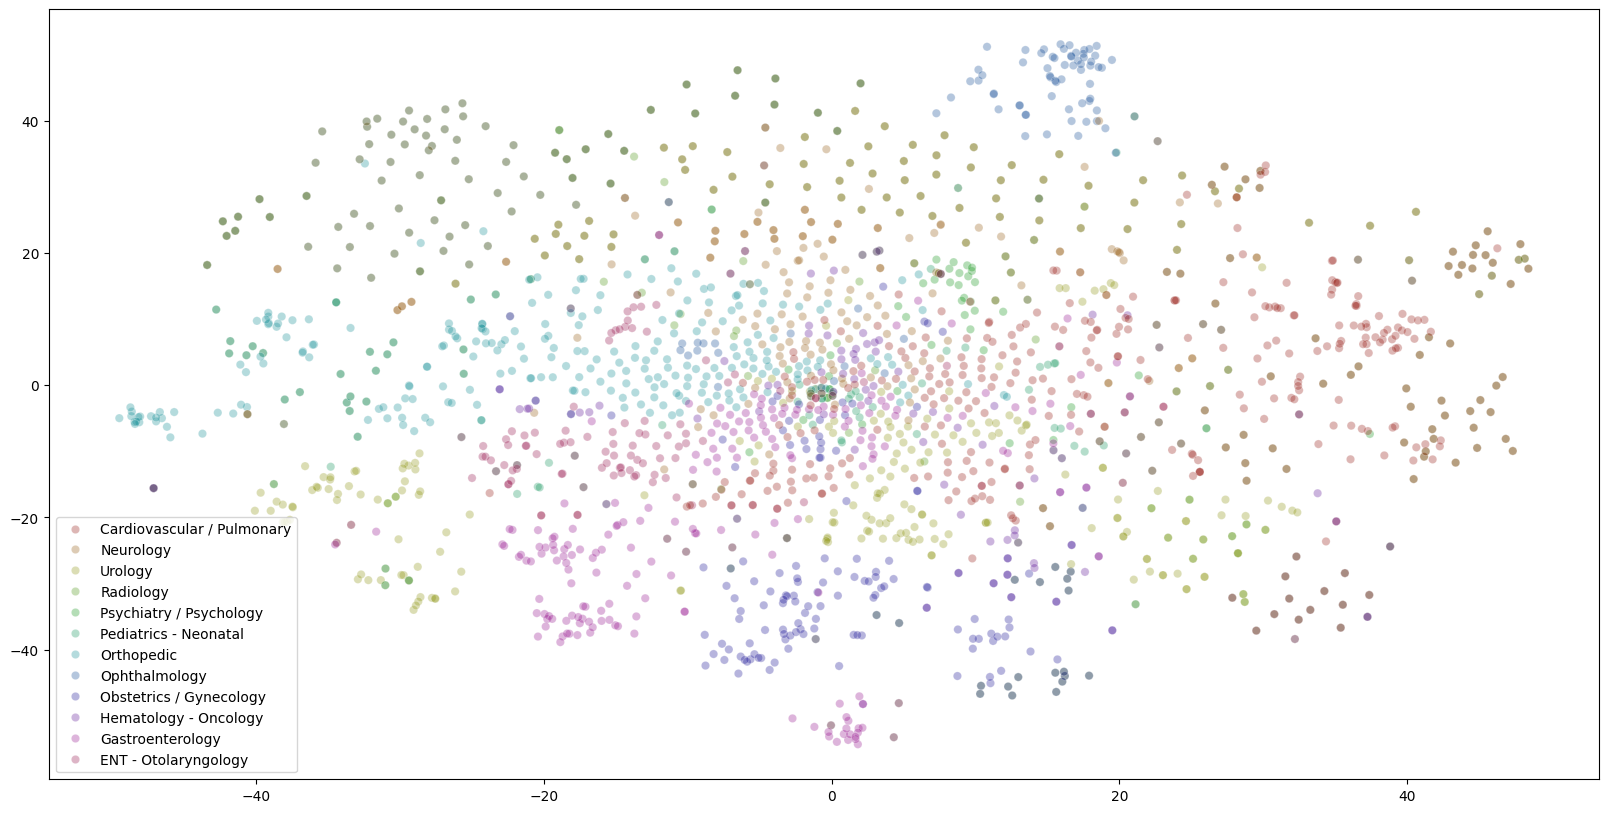

In [113]:
import gc
gc.collect()
tfIdfMatrix = np.array(tfIdfMat.todense())
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

# **MODELS**

# **Traditional Models**

### **TF-IDF CORe**

In [114]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = tfidf_vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(tfidf_vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen patient', 'abdomen pelvis', 'abdominal', 'abdominal aorta', 'abdominal patient', 'abdominal wall', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adhesion', 'adnexal', 'adrenal', 'adrenal gland', 'air', 'air cell', 'airway', 'airway patient', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allograft', 'alt', 'amniotic', 'amniotic fluid', 'anal', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior artery', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior descending', 'anterior posterior', 'anterolateral', 'antrum', 'aorta', 'aorta left', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'apical', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery anterior', 'artery artery', 'artery carotid', 'artery carotid artery', 'artery coronary', 'artery coronary artery', 'artery left', 'artery patient', 'artery 

In [115]:
gc.collect()
pca = PCA(n_components=0.95)

tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

In [116]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 540)
Test_Set_Size:(581, 540)


In [117]:
tfIdfMat_reduced

array([[-0.169421  ,  0.27254652, -0.07437958, ..., -0.01839187,
        -0.01512167,  0.00269317],
       [-0.1981462 ,  0.33488602, -0.08255933, ...,  0.01737439,
        -0.01996604,  0.00248711],
       [-0.19413348,  0.3500226 , -0.03750877, ...,  0.0081229 ,
        -0.022243  ,  0.00380261],
       ...,
       [-0.11005214,  0.38363678, -0.0563517 , ..., -0.01191803,
         0.01195799, -0.01004496],
       [-0.05968822,  0.32902238, -0.08956563, ..., -0.03595132,
        -0.0006378 ,  0.01609288],
       [-0.07363838,  0.47401618,  0.02431492, ...,  0.00388306,
         0.00408081,  0.01818088]])

### **Random Forest(TFIDF)**

In [118]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = RandomForestClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.50      0.70      0.58        93
                 Neurology       0.38      0.44      0.41        79
                   Urology       0.77      0.75      0.76        59
                 Radiology       0.02      0.01      0.02        68
   Psychiatry / Psychology       0.33      0.08      0.12        13
     Pediatrics - Neonatal       0.30      0.17      0.21        18
                Orthopedic       0.58      0.64      0.61        89
             Ophthalmology       0.79      0.71      0.75        21
   Obstetrics / Gynecology       0.70      0.59      0.64        39
     Hematology - Oncology       0.22      0.09      0.13        22
          Gastroenterology       0.76      0.68      0.72        56
      ENT - Otolaryngology       0.73      0.79      0.76        24

                  accuracy                           0.52       581
                 macro avg       0.51      0.4

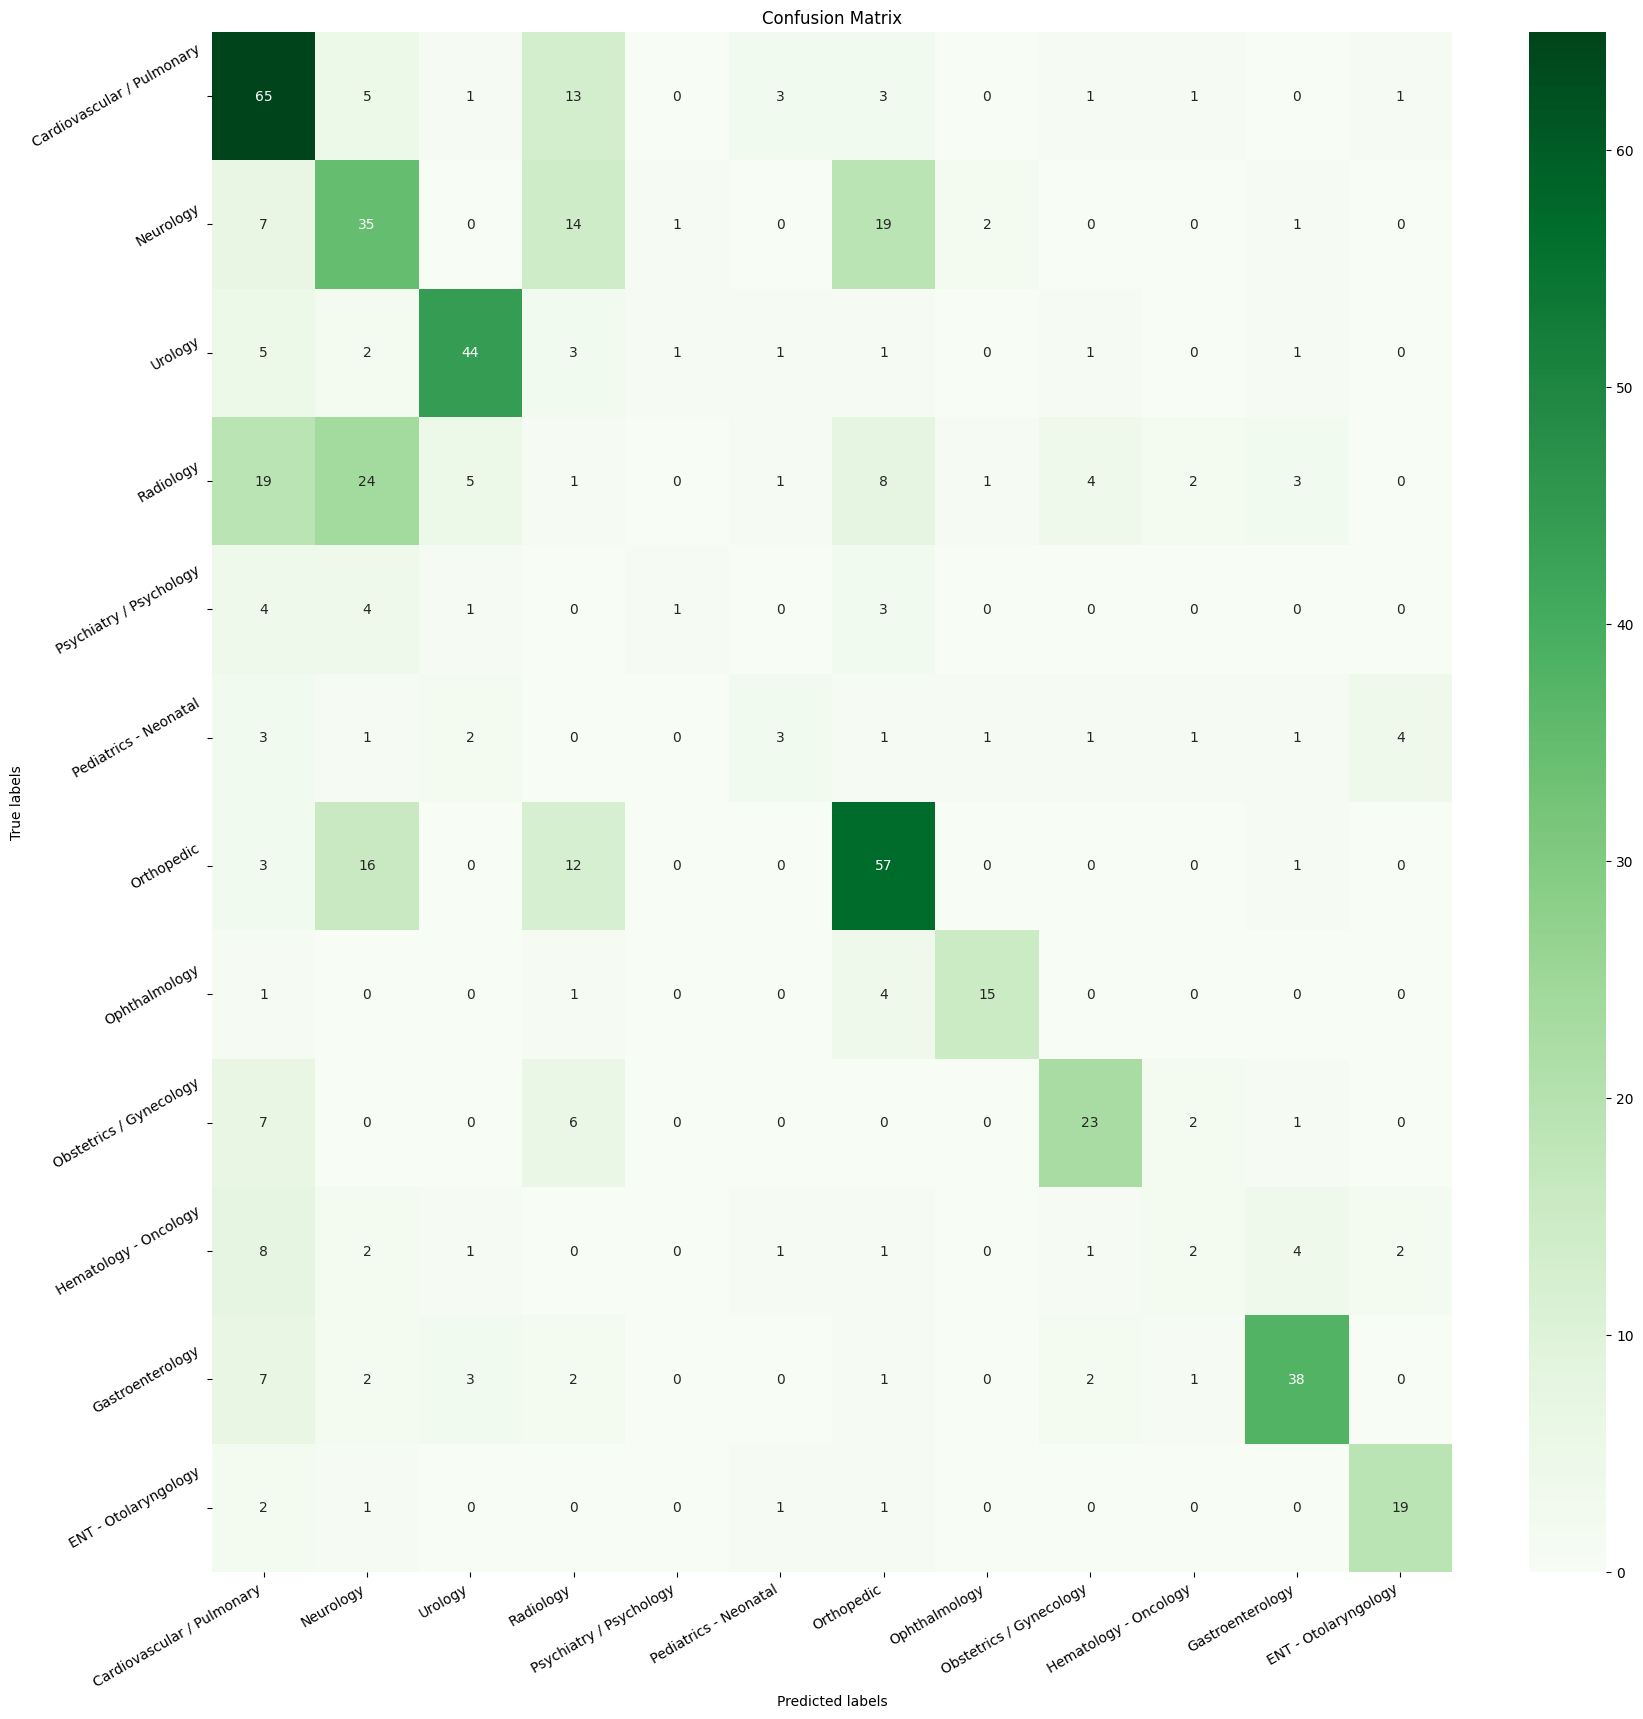

In [119]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### **XGboost(TFIDF)**

In [120]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = GradientBoostingClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.56      0.61      0.58        93
                 Neurology       0.37      0.42      0.39        79
                   Urology       0.71      0.76      0.74        59
                 Radiology       0.09      0.09      0.09        68
   Psychiatry / Psychology       0.33      0.23      0.27        13
     Pediatrics - Neonatal       0.19      0.17      0.18        18
                Orthopedic       0.59      0.60      0.59        89
             Ophthalmology       0.67      0.76      0.71        21
   Obstetrics / Gynecology       0.74      0.59      0.66        39
     Hematology - Oncology       0.27      0.18      0.22        22
          Gastroenterology       0.76      0.62      0.69        56
      ENT - Otolaryngology       0.68      0.71      0.69        24

                  accuracy                           0.51       581
                 macro avg       0.50      0.4

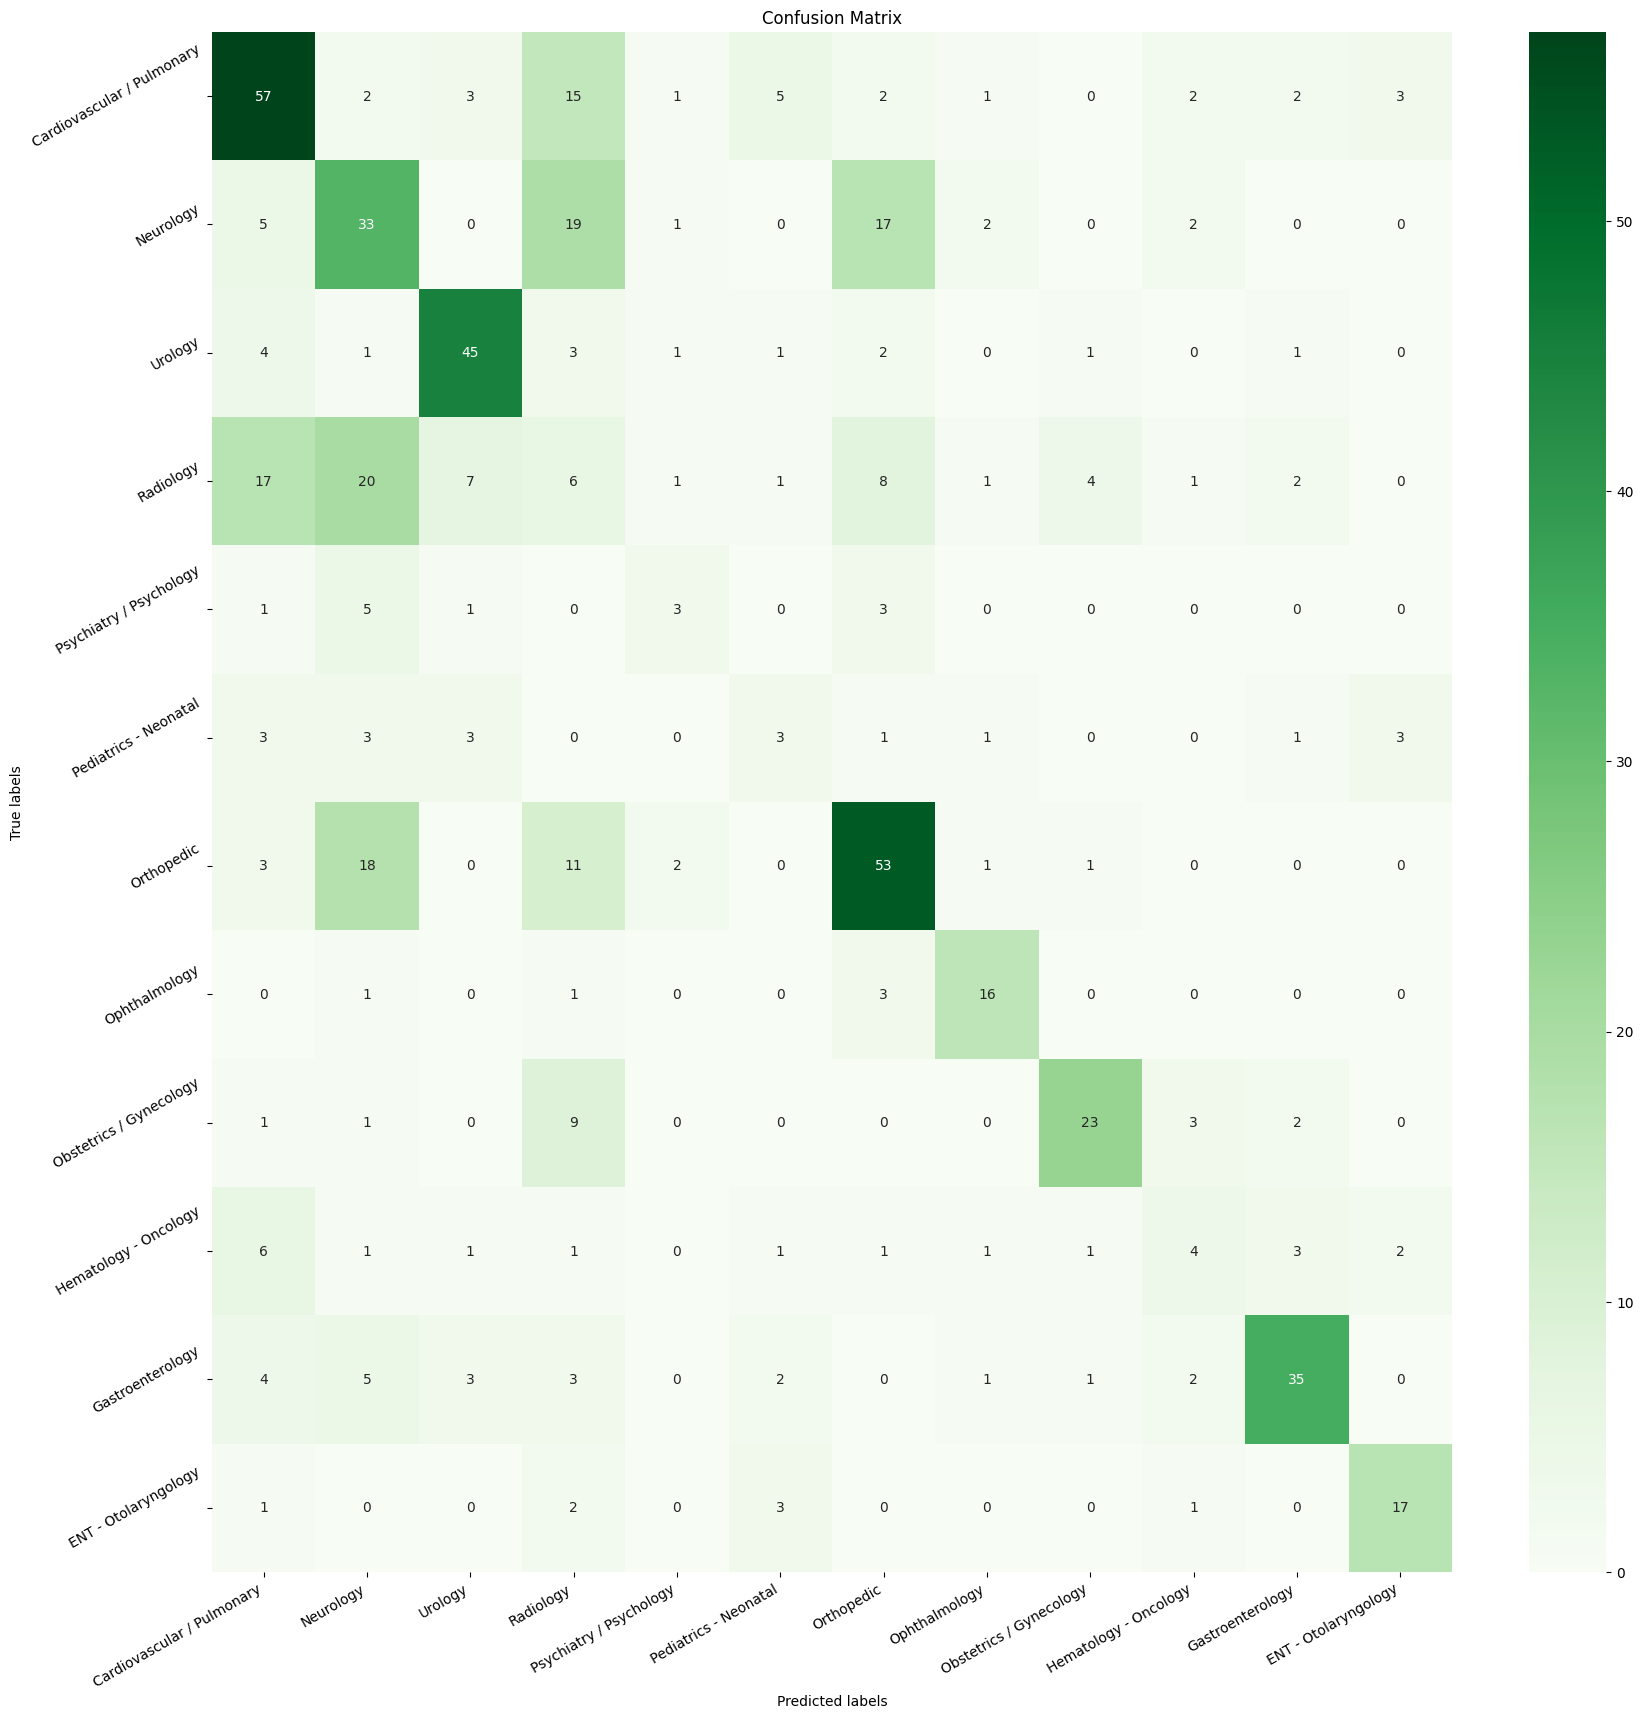

In [121]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### **LGBMClassifier(TFIDF)**

In [122]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = LGBMClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
print(classification_report(y_test,y_test_pred,labels=category_list))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137700
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 540
[LightGBM] [Info] Start training from score -1.835742
[LightGBM] [Info] Start training from score -3.186697
[LightGBM] [Info] Start training from score -2.339399
[LightGBM] [Info] Start training from score -3.243855
[LightGBM] [Info] Start training from score -1.991092
[LightGBM] [Info] Start training from score -2.709773
[LightGBM] [Info] Start training from score -3.336229
[LightGBM] [Info] Start training from score -1.879867
[LightGBM] [Info] Start training from score -3.512119
[LightGBM] [Info] Start training from score -3.774484
[LightGBM] [Info] Start training from score -2.140353
[LightGBM] [Info] Start training from score -2.281579
[LightGBM] [Warning] No further splits with positive gain, be

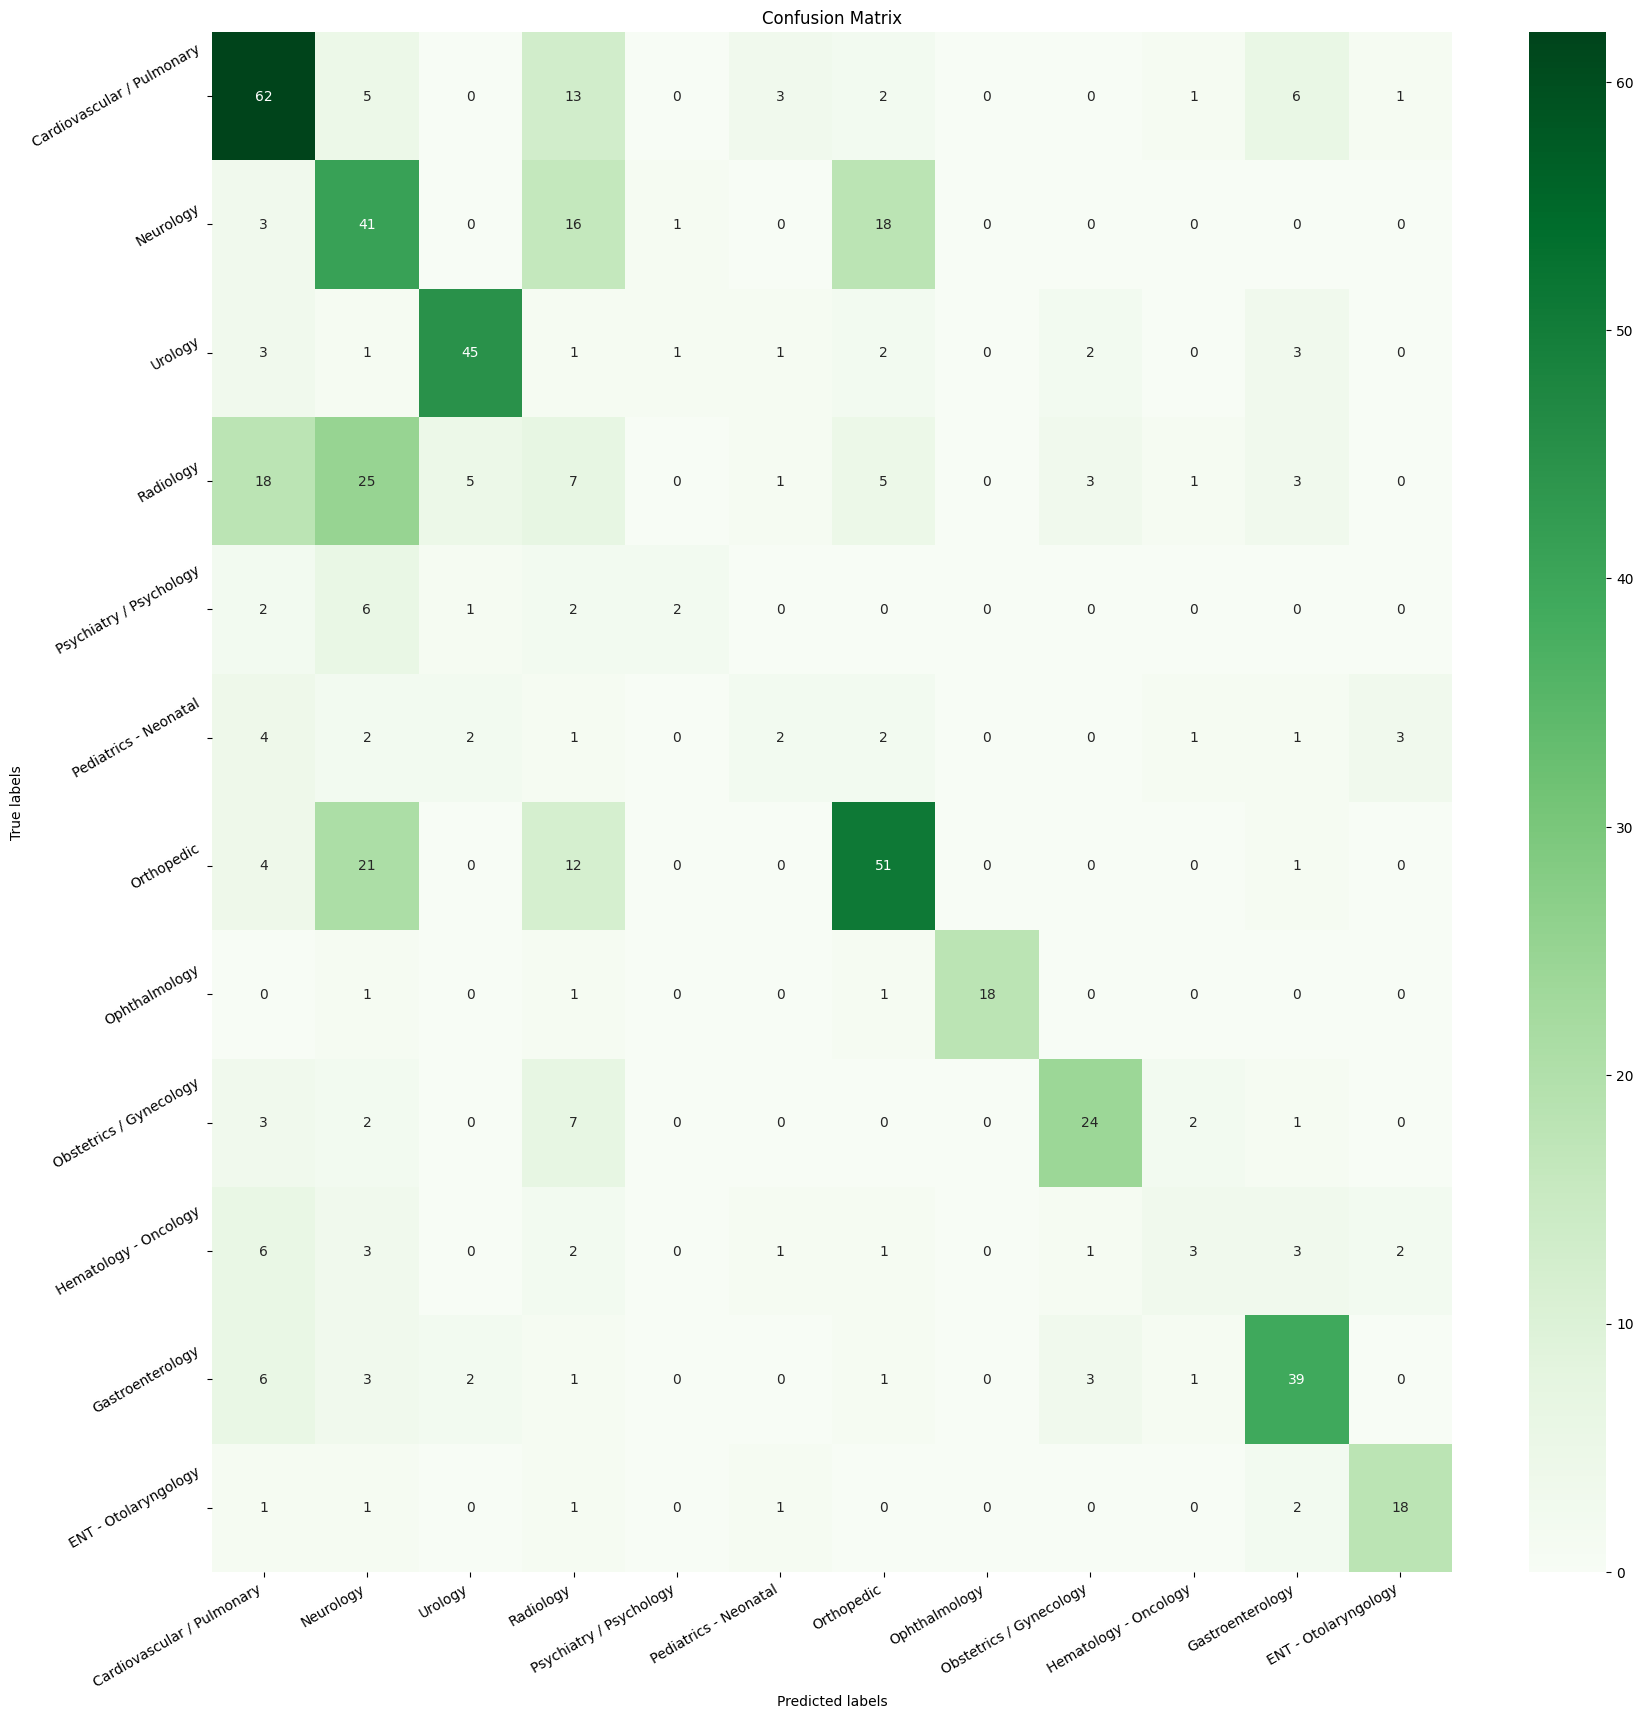

In [123]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### **MultinomialNB(TFIDF)**

In [124]:
from sklearn.preprocessing import StandardScaler

# Veriyi standardize etme
scaler = StandardScaler()
tfIdfMat_standardized = scaler.fit_transform(tfIdfMat.toarray())

#^PCA uygulama
pca = PCA(n_components=0.95)
tfIdfMat_reduced_nb = pca.fit_transform(tfIdfMat_standardized)

tfIdfMat_reduced_nb[tfIdfMat_reduced_nb < 0] = 0

labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
#^

In [125]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(tfIdfMat_reduced_nb, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train_nb.shape))
print('Test_Set_Size:'+str(X_train_nb.shape))

Train_Set_Size:(1743, 630)
Test_Set_Size:(1743, 630)


In [126]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = MultinomialNB().fit(X_train_nb, y_train_nb)
y_test_pred= clf.predict(X_test_nb)
print(classification_report(y_test_nb,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.60      0.55      0.57        93
                 Neurology       0.46      0.56      0.50        79
                   Urology       0.60      0.76      0.67        59
                 Radiology       0.19      0.18      0.18        68
   Psychiatry / Psychology       0.35      0.46      0.40        13
     Pediatrics - Neonatal       0.23      0.33      0.27        18
                Orthopedic       0.77      0.54      0.64        89
             Ophthalmology       0.89      0.81      0.85        21
   Obstetrics / Gynecology       0.71      0.69      0.70        39
     Hematology - Oncology       0.28      0.32      0.30        22
          Gastroenterology       0.85      0.62      0.72        56
      ENT - Otolaryngology       0.64      0.88      0.74        24

                  accuracy                           0.55       581
                 macro avg       0.55      0.5

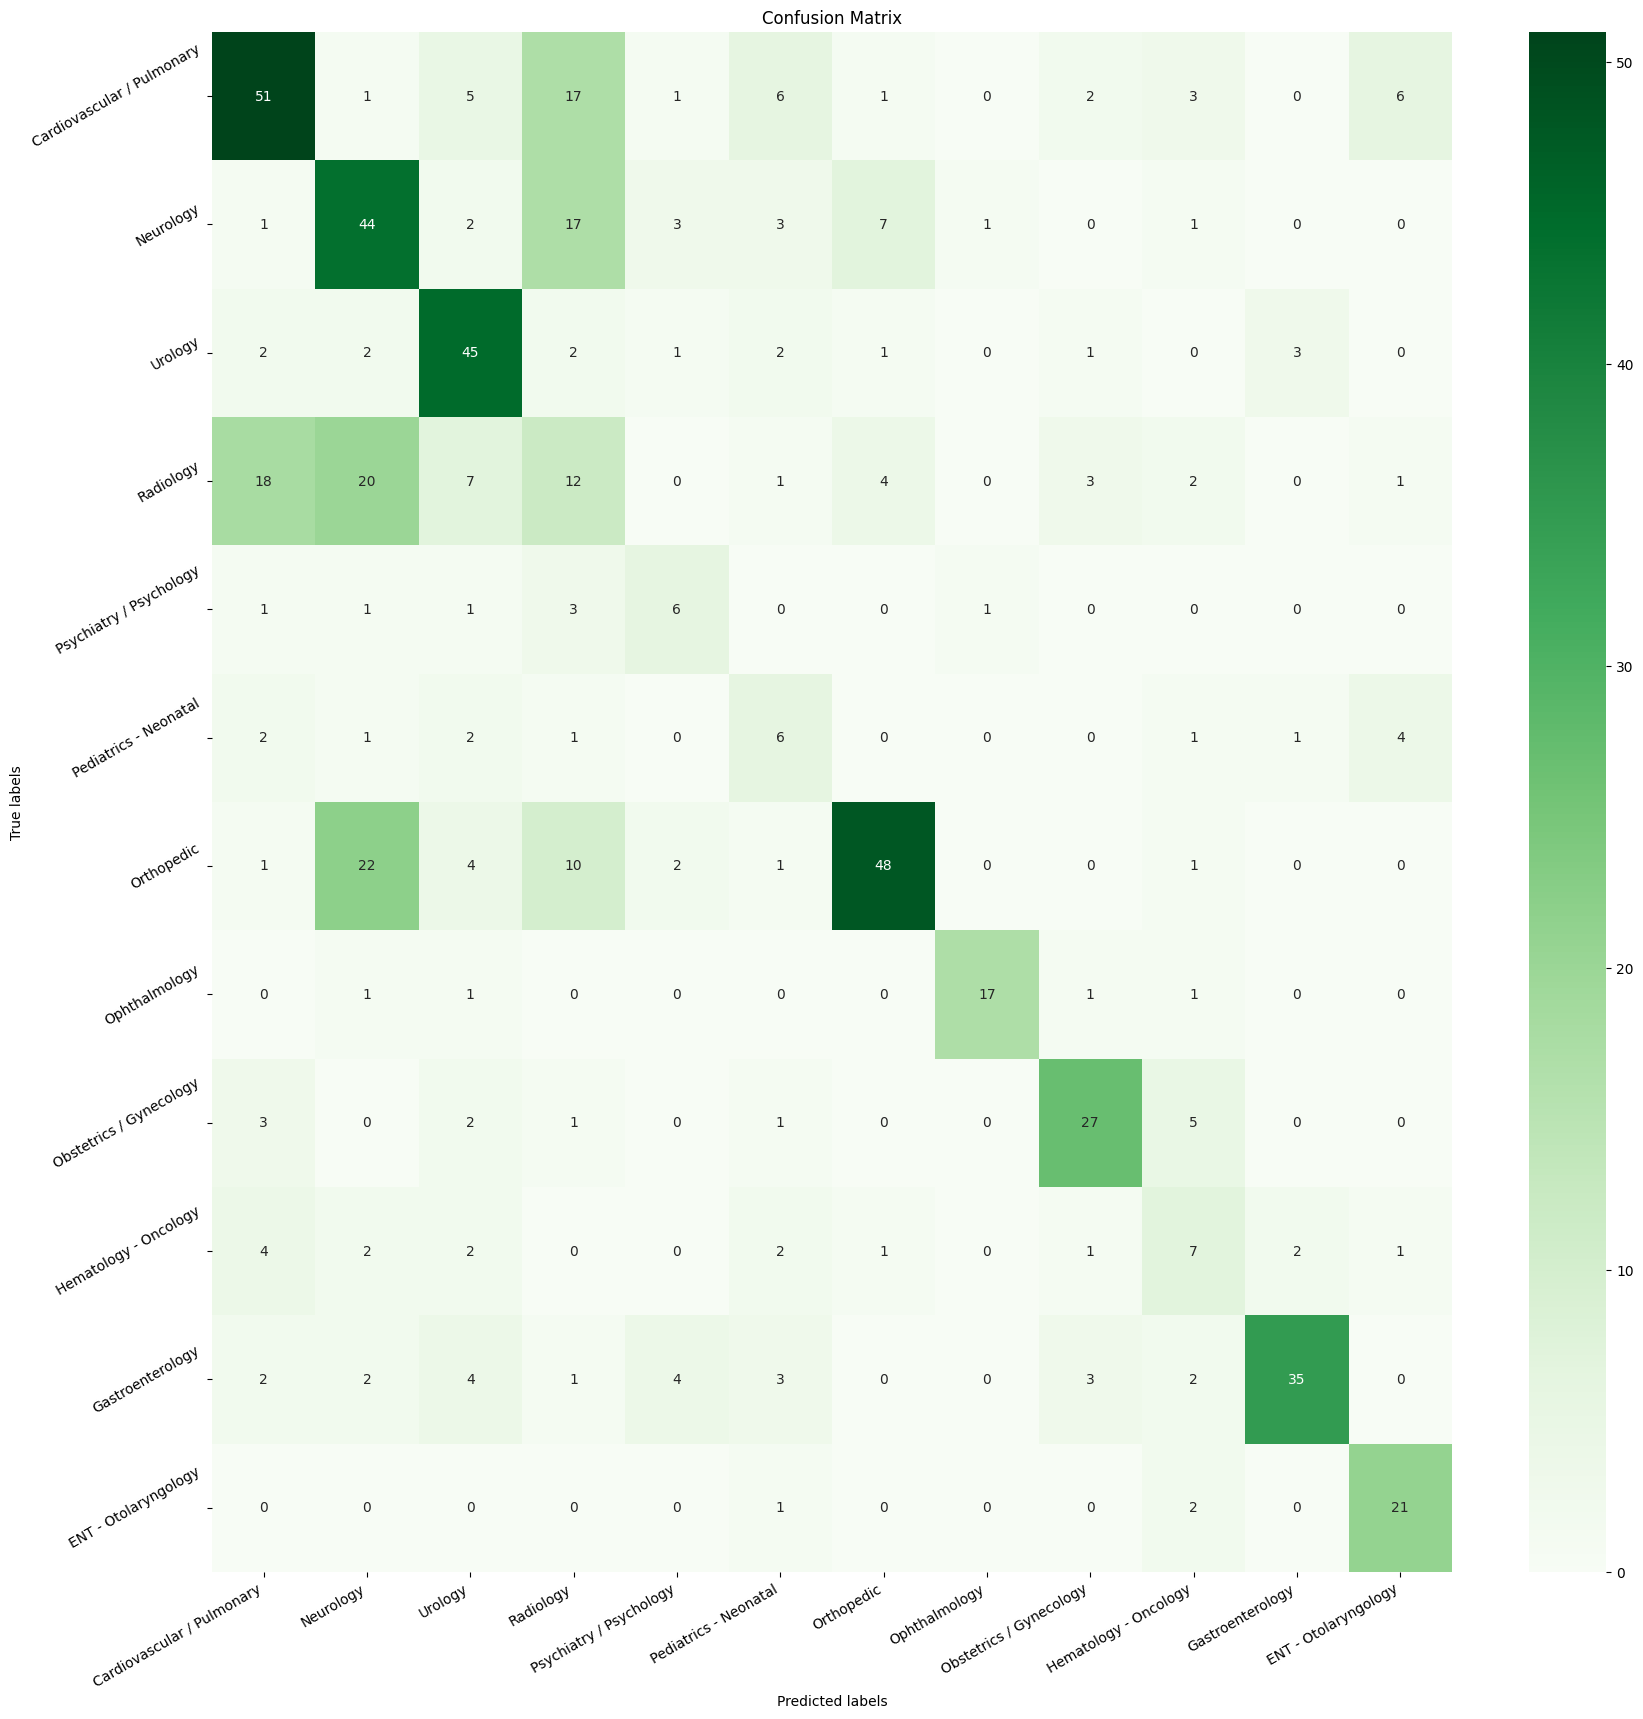

In [127]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [128]:
NER_text_df = pd.read_csv("/content/drive/MyDrive/output_mt.csv")

print(NER_text_df.columns)
NER_text_df.head(5)
NER_x_df = NER_text_df['Entity']
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels_NER = NER_text_df['Text']

X_train_NER, X_test_NER, y_train_NER, y_test_NER = train_test_split(NER_x_df, labels_NER, random_state=40)

Index(['Text', 'Start', 'End', 'Entity'], dtype='object')


### **Random Forest NER**

In [129]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = RandomForestClassifier().fit(X_train_NER, y_train_NER)
y_test_pred= clf.predict(X_test_NER)
print(classification_report(y_test_NER,y_test_pred,labels=category_list))

ValueError: could not convert string to float: 'DISEASE'

In [ ]:
labels = category_list
cm = confusion_matrix(y_test_NER, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### **XCBoost NER**

In [ ]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = GradientBoostingClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
print(classification_report(y_test,y_test_pred,labels=category_list))

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### LGBM **NER**

In [ ]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = LGBMClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
print(classification_report(y_test,y_test_pred,labels=category_list))

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### **Multinomial NER**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Veriyi standardize etme
scaler = StandardScaler()
tfIdfMat_standardized = scaler.fit_transform(tfIdfMat.toarray())

# PCA uygulama
pca = PCA(n_components=0.95)
tfIdfMat_reduced_nb = pca.fit_transform(tfIdfMat_standardized)

tfIdfMat_reduced_nb[tfIdfMat_reduced_nb < 0] = 0

labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

In [ ]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(tfIdfMat_reduced_nb, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train_nb.shape))
print('Test_Set_Size:'+str(X_train_nb.shape))

In [ ]:
# clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
clf = MultinomialNB().fit(X_train_nb, y_train_nb)
y_test_pred= clf.predict(X_test_nb)
print(classification_report(y_test_nb,y_test_pred,labels=category_list))

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [131]:

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] // 2, 2)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]//2,2)

# **Ensemble Learning**

In [132]:
from keras.models import Sequential,Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, GRU, concatenate, Dense,Flatten, Dropout
from keras.layers import GlobalMaxPooling1D

# Giriş verisi boyutları
# input_shape = X_train.shape
# num_classes = len(filtered_data_categories)
# vocab_size = 2324
# input_length=576
# embedding_dim = 100

vocab_size = 10000 # Kelime dağarcığının boyutu
embedding_dim = 100 # Gomme boyutu
num_classes = len(category_list) # Sinif sayis1

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_train.shape[1]))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(LSTM(units=128, activation='tanh', input_shape=(X_train.shape[1], 2), return_sequences=True))
cnn_model.add(Dropout(0.5))
cnn_model.add(GRU(units=128, activation='tanh'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='sigmoid'))



# Modeli derleme
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
label_mapping = {label: idx for idx, label in enumerate(category_list)}


y_train_numeric = [label_mapping[label] for label in y_train]
y_test_numeric = [label_mapping[label] for label in y_test]


from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train_numeric, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_numeric, num_classes=num_classes)


history = cnn_model.fit(
    X_train,
    y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=128
)
# y_test_pred = cnn_model.predict(X_test)
# print(classification_report(y_test_numeric, y_test_pred))

# # CNN modeli
# cnn_model = Sequential()
# cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(MaxPooling1D())
# cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(Dense(1, activation='sigmoid'))

# # LSTM modeli

# cnn_model.add(LSTM(64, activation = "tanh"))

# cnn_model.add(Dense(1, activation='sigmoid'))



# # GRU modeli
# # Model oluşturma

# # cnn_model.add(GRU(32, activation = "tanh"))
# cnn_model.add(Dense(1, activation='sigmoid'))
# cnn_model.add(Flatten())
# history_gru = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_test, y_test))


# Ensemble modeli
# combined = concatenate([cnn_model.output, lstm_model.output, gru_model.output])
# dense1 = Dense(256, activation='relu')(combined)
# output = Dense(num_classes, activation='softmax')(dense1)


# combined = concatenate([cnn_model.output, lstm_model.output, gru_model.output])
# dense1 = Dense(256, activation='relu')(combined)
# output = Dense(num_classes, activation='softmax')(dense1)

# ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, gru_model.input], outputs=output)


# Modelin derlenmesi
# ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 540, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 536, 128)          64128     
                                                                 
 dropout_3 (Dropout)         (None, 536, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 536, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 536, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

# **SMOTE**

In [135]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(X_train, y_train_categorical)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1485, 540)
Test_Set_Size:(496, 540)


In [139]:
from keras.models import Sequential,Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, GRU, concatenate, Dense,Flatten, Dropout
from keras.layers import GlobalMaxPooling1D

# Giriş verisi boyutları
# input_shape = X_train.shape
# num_classes = len(filtered_data_categories)
# vocab_size = 2324
# input_length=576
# embedding_dim = 100

vocab_size = 10000 # Kelime dağarcığının boyutu
embedding_dim = 100 # Gomme boyutu
num_classes = len(category_list) # Sinif sayis1

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_train.shape[1]))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(LSTM(units=128, activation='tanh', input_shape=(X_train.shape[1], 2), return_sequences=True))
cnn_model.add(Dropout(0.5))
cnn_model.add(GRU(units=128, activation='tanh'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='sigmoid'))



# Modeli derleme
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
label_mapping = {label: idx for idx, label in enumerate(category_list)}



history = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=128
)
# y_test_pred = cnn_model.predict(X_test)
# print(classification_report(y_test_numeric, y_test_pred))

# # CNN modeli
# cnn_model = Sequential()
# cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(MaxPooling1D())
# cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(Dense(1, activation='sigmoid'))

# # LSTM modeli

# cnn_model.add(LSTM(64, activation = "tanh"))

# cnn_model.add(Dense(1, activation='sigmoid'))



# # GRU modeli
# # Model oluşturma

# # cnn_model.add(GRU(32, activation = "tanh"))
# cnn_model.add(Dense(1, activation='sigmoid'))
# cnn_model.add(Flatten())
# history_gru = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_test, y_test))


# Ensemble modeli
# combined = concatenate([cnn_model.output, lstm_model.output, gru_model.output])
# dense1 = Dense(256, activation='relu')(combined)
# output = Dense(num_classes, activation='softmax')(dense1)


# combined = concatenate([cnn_model.output, lstm_model.output, gru_model.output])
# dense1 = Dense(256, activation='relu')(combined)
# output = Dense(num_classes, activation='softmax')(dense1)

# ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, gru_model.input], outputs=output)


# Modelin derlenmesi
# ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 540, 100)          1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 536, 128)          64128     
                                                                 
 dropout_12 (Dropout)        (None, 536, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 536, 128)          131584    
                                                                 
 dropout_13 (Dropout)        (None, 536, 128)          0         
                                                                 
 gru_4 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_14 (Dropout)        (None, 128)              

In [140]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

ValueError: Found input variables with inconsistent numbers of samples: [496, 581]

In [141]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [142]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

In [143]:
mask = clinical_text_df['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = clinical_text_df[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays